In [1]:
import numpy as np
from math import exp
from numpy.random import binomial,shuffle,seed, choice
import pandas as pd
from IPython.display import display, clear_output
import os
from time import sleep
from CompactLSM import ID_to_ind, class_of_sample, plot_spikes, classifier

Reservoir Dimension set

In [2]:
nx = 5
ny = 5
nz = 5
N = nx*ny*nz                                          # Reservoir size

N_read = 10                                           # No. of Readout neurons

Important constants related to LIF neuron and synaptic model

In [3]:
global vrest, vth, t_refrac
vrest, vth, t_refrac = 0, 20, 2

tau_m = 32
params_potential = {'C':1, 'g_L':1/tau_m, 'E_L':vrest, 'V_T':vth, 'R_p':t_refrac}

Delay = 1 #constant delay for all synapses in ms

tau_c = 64
C_theta = 5
del_C = 3
n_bits = 8
delta_c = 1
params_conc = {'C_theta':C_theta, 'del_C':del_C, 'tau_c':64, 'nbits':n_bits, 'delta_c':delta_c}

syn_string = "first-order"

sampling_freq = 12.5 # in khz
h = 1 # in ms

time_params = {'h':h, 'Delay':Delay}

Set Reservoir Connections

In [4]:
# Storing the IDs of the neurons
LSM_ID = np.zeros((nx,ny,nz),dtype=np.int64)
l = 0
for i in range(nx):
    for j in range(ny):
        for k in range(nz):
            LSM_ID[i,j,k] = l
            l = l + 1

# Storing the synapse connections, and creating the initial weight matrix

k_prob = [0.45, 0.3, 0.6, 0.15]
r_sq = 2**2

W_arr = [3, 6, -2, -2]
W_init = 3
Weights_temp = np.zeros((N,N))

N_in = int(N*0.8)
neuron_type = [ int(i<N_in) for i in range(N)]
seed(4)
shuffle(neuron_type) # 1 for excitatory, 0 for inhibitory

synapes = [dict() for i in range(N)]    # an array of dictonaries which store the location of neuron, 
                                        # type of neuron, and the IDs of the neurons it is connected to

for l in range(N):
    loc = ID_to_ind(nx,ny,nz,l)
    n_type = neuron_type[l]
    cons = []
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                if l != int(LSM_ID[i,j,k]):
                    dist_sq = (loc[0]-i)**2 + (loc[1]-j)**2 + (loc[2]-k)**2
                    k_probl = 0
                    if n_type == 1:
                      if neuron_type[int(LSM_ID[i,j,k])] == 1:
                        k_probl = k_prob[0]
                        W_init = W_arr[0]
                      else:
                        k_probl = k_prob[1]
                        W_init = W_arr[1]
                    else:
                      if neuron_type[int(LSM_ID[i,j,k])] == 1:
                        k_probl = k_prob[2]
                        W_init = W_arr[2]
                      else:
                        k_probl = k_prob[3]
                        W_init = W_arr[3]

                    probability = k_probl* exp(-1*dist_sq/r_sq)
#                     print(probability)
                    check = binomial(1,probability)
                    if check == 1:
                        cons.append(int(LSM_ID[i,j,k]))
                        Weights_temp[l,int(LSM_ID[i,j,k])] = W_init    
    synapes[l] = {"Location":loc, "Neuron_type":n_type, "connections":cons}

global Weights
Weights = Weights_temp
print("Total synapse:", len(np.argwhere(Weights!=0)), 
        ",E --> E :", len(np.argwhere(Weights==3)), 
        ",E --> I:",len(np.argwhere(Weights==6)),
        ",I --> E/I:",len(np.argwhere(Weights==-2)))
i = 64
print("Total Connections: for neuron {}:{}, {}".format(i,synapes[i]["Neuron_type"],synapes[i]["connections"]) )

Total synapse: 1130 ,E --> E : 769 ,E --> I: 105 ,I --> E/I: 256
Total Connections: for neuron 64:1, [19, 62, 83, 84, 89, 93, 97, 109, 114, 118]


In [5]:
Weights[:,0]

array([ 0.,  3.,  0.,  3.,  0.,  3.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0., -2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  3.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

Set Readout neuron initial Weights

In [6]:
All_labels = [str(x) for x in range(10)]
# N_read = 10                                           # No. of Readout neurons
W_init_read = 1                                       # Initial weight, equal for all, update with learning
Weights_temp_readOut = W_init_read*np.ones((N_read, N), dtype='float')


synapes_read = []        # an array of dictonaries which store the label of neuron, 
                                                      # and the IDs of the neurons it is connected to

for l in range(N_read):
    label = All_labels[l]
    synapes_read.append(label)

Weights_readOut = Weights_temp_readOut

In [7]:
# creating file location and label arrays for train and validate

base = 'PreProcessing/trainBSA'
os.listdir(base)

train_Labels = []
file_name_List = []

for human in os.listdir(base):
    base_up = base + '/' + human
    for train_sample in os.listdir(base_up):
        train_Label = train_sample[0:2]
        file_loc = base_up + '/' + train_sample
        file_name_List.append(file_loc)
        train_Labels.append(train_Label)

seedval = 4

seed(seedval)
shuffle(train_Labels)
seed(seedval)
shuffle(file_name_List)

total_size = len(train_Labels)
train_size = int(total_size*0.8)

validate_Labels = train_Labels[train_size:total_size]
validate_file_list = file_name_List[train_size:total_size]

train_Labels = train_Labels[0:train_size]
train_file_list = file_name_List[0:train_size]

In [8]:
L = 78
Fin = 4
reservoir_ID = [i for i in range(N)]
Input_ID = [i for i in range(L)]
seed(seedval)
Input_CXNs = choice(reservoir_ID, size = (L,Fin))
Input_CXNs = {i:Input_CXNs[i] for i in range(L)}
sign_win_matrix = (binomial(1,1/2, size = (L, Fin)) - 0.5)*2
# Input_CXNs * sign_win_matrix

In [9]:
Input_fanIn = {}
w_in = 8
for i in range(N):
    Input_fanIn[i] = [[],[]]
    for key, CxN in Input_CXNs.items():
        an_array = np.where(CxN == i)
        if an_array[0].size != 0:
            Input_fanIn[i][0].append(key)
            Input_fanIn[i][1].append(sign_win_matrix[key, an_array[0]][0])
# Input_fanIn            

In [10]:
def Input_current_gen(file_name_List, syn_string, N, time_params, training=False, train_Labels=None):
    input_num = 0
    h, Delay = time_params.values()
    for idx in range(len(file_name_List)):
        data = pd.read_csv(file_name_List[idx], sep=",", header=None)
        data_as_numpy = data.to_numpy()
        input = data_as_numpy.transpose()   # Single Sample input
        (L,M) = input.shape
        In_neurons = input   # spike train of L input neurons, over M timesteps, 1 if spike, 0 if no spike
        time = np.array([j*h for j in range(M)],dtype=np.float64)


                        
        train_Label = class_of_sample(train_Labels[idx]) if training else "Null"
        input_num += 1
        yield In_neurons, L, M, train_Label, input_num

### Finding input neurons to reservoir current and then using the spike train to find the current input to the reservoir

In [11]:
print("Size of Reservoir =",nx,"X",ny,"X",nz,",Total total neurons =",N)
print("Total no.of read out neurons =",N_read)

Size of Reservoir = 5 X 5 X 5 ,Total total neurons = 125
Total no.of read out neurons = 10


In [12]:
# # if need to exit training load last trained weights
# load_idx = 20
# Weights_readOut_fromCsv = pd.read_csv("Weights/weights_epoch{}.csv".format(load_idx), sep=",", header=None)
# Weights_readOut = Weights_readOut_fromCsv.to_numpy()

#### RESERVOIR Functions

In [13]:
def LIF(V_neuron_prev,I_input,N,h,index_next,index_prev_spike, params):
    C, g_L, v_rest, V_T, R_p = params.values()
    R_p_ind = np.math.ceil(R_p/h)
#     print("New", I_input)
    V_neuron_next = v_rest*np.ones((N,), dtype=np.float64)
    Spike_next = np.zeros((N,), dtype=np.int64)
    V_temp = V_neuron_prev - V_neuron_prev * g_L * h + I_input * h 
    for i in range(N):
            if index_next-index_prev_spike[i] < R_p_ind:
                V_neuron_next[i] = v_rest
            elif V_temp[i] < V_T:
                V_neuron_next[i] = V_temp[i] 
            else:
                Spike_next[i]  = np.int64(1)
                V_neuron_next[i] = V_temp[i]
    
    return V_neuron_next, Spike_next 

In [14]:
def syn_res(syn_string, t, spikes_i,w_ij,del_i,h, type_syn=None):  
    # spike in neuron i, produces a synaptic current in neuron j, weight = w_ij

    syn_curr = 0
    spikes_loc = np.where(spikes_i == 1)

    if syn_string == "static":
        for spike_loc in spikes_loc:
            if np.where(spike_loc + np.int64(del_i/h) == t)[0].size != 0: 
                syn_curr += w_ij/h
       
    elif syn_string == "first-order":
        tau_s = 4
        for spike_loc in spikes_loc[0]:
            if t - spike_loc - np.int64(del_i/h) >= 0:
                temp = w_ij/h * (1/tau_s) * np.exp(-(h/tau_s)*(t - spike_loc - np.int64(del_i/h)))
                syn_curr += temp 

               
    return syn_curr

In [15]:
def reservoir_solver(N, Delay, synapes, M, h, spike_train, params_potential, Weights, syn_string):

    C, g_L, vrest, V_T, R_p = params_potential.values()
    
    I_syn = np.zeros((N,M),dtype=np.float64)
    V_neurons = vrest*np.ones((N,M),dtype=np.float64) # potential of each neuron at every time instant
    Spikes = np.zeros((N,M),dtype=np.int64)         # 1 if ith neuron spikes at jth time step

    syn_string = "static"
    
    index_prev_spike = -1*(M)*np.ones((N,),dtype=np.int64)

    time = np.array([j*h for j in range(M)],dtype=np.float64)
    
    for t in range(1, M):
        for i in range(N):
            # Fan in from input spike train at time t
            Input_fanIN_now = Input_fanIn[i]
#             print(Input_fanIN_now)
            Input_current = 0
            for j in range(len(Input_fanIN_now[0])):
                spikes_i = spike_train[Input_fanIN_now[0][j], :]
                w_ij = Input_fanIN_now[1][j] * w_in 
                Input_current += syn_res(syn_string, t , spikes_i,w_ij,Delay,h)
                

            # Fan in from reservoir at time t
            reservoir_fanIn_now = synapes[i]["connections"]
            res_current = 0
            for j in range(len(reservoir_fanIn_now)):
                spikes_i = Spikes[reservoir_fanIn_now[j], :]
                w_ij = np.float64(Weights[j,i])
                res_current += syn_res(syn_string, t , spikes_i,w_ij,Delay,h)
            
            I_syn[i, t] = Input_current + res_current  
            
        # solve for neuron potential and check if spike is produced
        V_neuron, Spike = LIF(V_neurons[:,t-1],I_syn[:,t],N,h,t,index_prev_spike, params_potential)  
        V_neurons[:,t] = V_neuron
        Spikes[:,t] = Spike
        
        for i in range(N):
            if int(Spike[i]) == 1:
                index_prev_spike[i] = t
    np.set_printoptions(threshold=np.inf)
#     print("Spikes", Spikes)
#     sleep(1)
    return V_neurons, Spikes

In [16]:
Input_fanIn[2]

[[53, 66], [1.0, 1.0]]

In [17]:
All_spikes_dat = {i:{"Input_spikes": [], "Reservoir_spikes": []} for i in range(len(train_Labels))}
for epoch in range(500):
    print("="*50)
    Input_gen_func = Input_current_gen(train_file_list, syn_string, N, time_params,training=True, train_Labels=train_Labels)
    NUM_INPUTS = len(train_Labels)
    
    for i in range(NUM_INPUTS):
        In_spikes, L, M, train_Label,input_num = next(Input_gen_func)      # Generates next input  
#         plot_spikes(In_spikes, L, M)
        [Reservoir_potential, Reservoir_Spikes] = reservoir_solver(N, Delay, synapes, M, h, In_spikes, 
                                                                          params_potential, Weights, syn_string)
#         plot_spikes(Reservoir_Spikes, N, M)
        All_spikes_dat[train_Label]["Input_spikes"].append((In_spikes, L, M)) 
        All_spikes_dat[train_Label][ "Reservoir_spikes"].append((Reservoir_Spikes, N, M)) 
        print("\n", "Training Label:", train_Label, "Input number:", i+1,
              "Res_spikes:", len(np.argwhere(Reservoir_Spikes==1)), end='')


 Training Label: 0 Input number: 1 Res_spikes: 714
 Training Label: 3 Input number: 2 Res_spikes: 612
 Training Label: 0 Input number: 3 Res_spikes: 601
 Training Label: 9 Input number: 4 Res_spikes: 709
 Training Label: 4 Input number: 5 Res_spikes: 511
 Training Label: 2 Input number: 6 Res_spikes: 685
 Training Label: 9 Input number: 7 Res_spikes: 700
 Training Label: 2 Input number: 8 Res_spikes: 518
 Training Label: 6 Input number: 9 Res_spikes: 565
 Training Label: 5 Input number: 10 Res_spikes: 600
 Training Label: 4 Input number: 11 Res_spikes: 567
 Training Label: 6 Input number: 12 Res_spikes: 547
 Training Label: 6 Input number: 13 Res_spikes: 667
 Training Label: 3 Input number: 14 Res_spikes: 558
 Training Label: 7 Input number: 15 Res_spikes: 558
 Training Label: 6 Input number: 16 Res_spikes: 569
 Training Label: 3 Input number: 17 Res_spikes: 721
 Training Label: 4 Input number: 18 Res_spikes: 819
 Training Label: 5 Input number: 19 Res_spikes: 656
 Training Label: 4 I

KeyboardInterrupt: 

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn import svm
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
matplotlib.rcParams['text.usetex'] = True
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'large',
          'figure.figsize': (6.4 * 2, 4.8 * 2),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium',
         'figure.titlesize':'xx-large'}
pylab.rcParams.update(params)

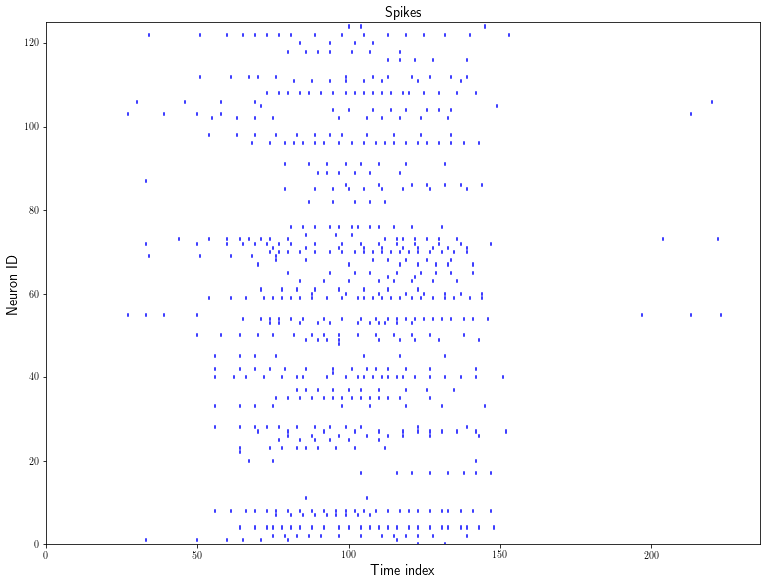

In [25]:
label_now = 3
In_spikes, L, M = All_spikes_dat[label_now]["Reservoir_spikes"][0]
plot_spikes(In_spikes, L, M )

**All spikes of class 0**

In [ ]:
label_now = 0
for i in range(len(All_spikes_dat[label_now]["Input_spikes"])):
    print("="*50)
    In_spikes, L, M = All_spikes_dat[label_now]["Input_spikes"][i]
    plot_spikes(In_spikes, L, M )
    Reservoir_Spikes, N, M = All_spikes_dat[label_now]["Reservoir_spikes"][i]
    plot_spikes(Reservoir_Spikes, N, M)
    print(M)

**All spikes of class 3**

In [ ]:
label_now = 3
for i in range(len(All_spikes_dat[label_now]["Input_spikes"])):
    print("="*50)
    In_spikes, L, M = All_spikes_dat[label_now]["Input_spikes"][i]
    plot_spikes(In_spikes, L, M )
    Reservoir_Spikes, N, M = All_spikes_dat[label_now]["Reservoir_spikes"][i]
    plot_spikes(Reservoir_Spikes, N, M)

**All spikes of class 6**

In [ ]:
label_now = 6
for i in range(len(All_spikes_dat[label_now]["Input_spikes"])):
    print("="*50)
    In_spikes, L, M = All_spikes_dat[label_now]["Input_spikes"][i]
    plot_spikes(In_spikes, L, M )
    Reservoir_Spikes, N, M = All_spikes_dat[label_now]["Reservoir_spikes"][i]
    plot_spikes(Reservoir_Spikes, N, M)

**All spikes of class 9**

In [ ]:
label_now = 9
for i in range(len(All_spikes_dat[label_now]["Input_spikes"])):
    print("="*50)
    In_spikes, L, M = All_spikes_dat[label_now]["Input_spikes"][i]
    plot_spikes(In_spikes, L, M )
    Reservoir_Spikes, N, M = All_spikes_dat[label_now]["Reservoir_spikes"][i]
    plot_spikes(Reservoir_Spikes, N, M)

**Linear Classifier**<br>
Fisher’s Discriminant Ratio

In [ ]:
def linear_trainer(All_spikes_dat, class_labels):
    
    for i in range(len(All_spikes_dat[label_now]["Reservor_spikes"])):
        
        
        
        